In [20]:
from IPython.display import Image
%matplotlib inline

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

In [21]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
#X = iris.data
y = iris.target

Splitting data into 70% training and 30% test data:

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

Standardizing the features:

In [23]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Training a perceptron model via scikit-learn

Redefining the `plot_decision_region` function from chapter 2:

In [24]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=42)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=42)

In [25]:
y_test_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_test_pred).sum())

Misclassified samples: 2


In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[14,  1,  0],
       [ 1, 14,  0],
       [ 0,  0, 15]])

Confusion matrix:  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy score: ", accuracy_score(y_test, y_test_pred))
print("Precision score: ", precision_score(y_test, y_test_pred, average=None))
print("Recall score: ", recall_score(y_test, y_test_pred, average=None))

Accuracy score:  0.9555555555555556
Precision score:  [0.93333333 0.93333333 1.        ]
Recall score:  [0.93333333 0.93333333 1.        ]


## Visualize the Model 

In [28]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

Graph the perceptron model

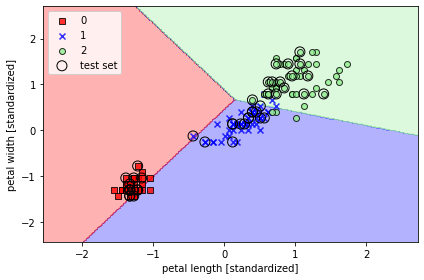

In [29]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

# Modeling class probabilities via logistic regression

### Logistic regression intuition and the cost function

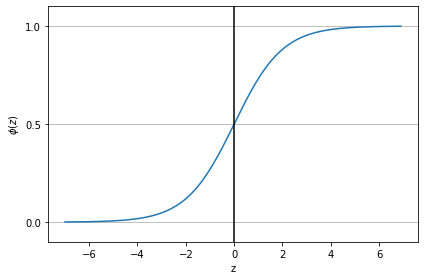

In [30]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

### Learning the weights of the logistic cost function

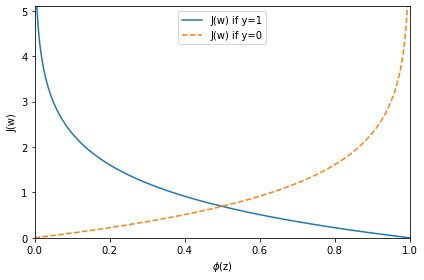

In [31]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

In [32]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

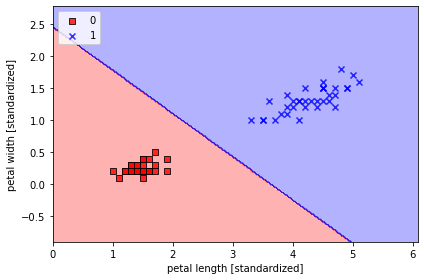

In [33]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

## Training a logistic regression model with scikit-learn

### Exercise: Use the logistic regression model in scikit-learn to train the Iris date set. Print out the precision, acuracy and recall score on the test dateset. And plot the decision region.  

In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", random_state=1, multi_class="ovr")
lr.fit(X_train_std, y_train)

LogisticRegression(multi_class='ovr', random_state=1)

In [43]:
y_test_pred = lr.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_test_pred).sum())

Misclassified samples: 1


In [44]:
confusion_matrix(y_test, y_test_pred)

array([[15,  0,  0],
       [ 0, 14,  1],
       [ 0,  0, 15]])

In [45]:
print("Accuracy score: ", accuracy_score(y_test, y_test_pred))
print("Precision score: ", precision_score(y_test, y_test_pred, average=None))
print("Recall score: ", recall_score(y_test, y_test_pred, average=None))

Accuracy score:  0.9777777777777777
Precision score:  [1.     1.     0.9375]
Recall score:  [1.         0.93333333 1.        ]


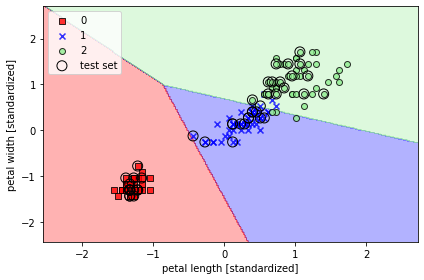

In [46]:
plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

In [47]:
lr.predict_proba(X_test_std[:3, :])

array([[4.34030239e-04, 2.40177991e-01, 7.59387979e-01],
       [7.98497856e-01, 2.01272608e-01, 2.29535868e-04],
       [8.15957089e-01, 1.83932672e-01, 1.10238778e-04]])

In [48]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [49]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [50]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])